In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import random
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, ZeroPadding2D
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.metrics import AUC
from sklearn.metrics import roc_auc_score, roc_curve, auc
from matplotlib.colors import LinearSegmentedColormap
from termcolor import colored
import pandas as pd
import seaborn as sns
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout,BatchNormalization, Activation, Input,concatenate
from tensorflow.keras.models import Model

# Set seed for reproducibility of results
seed_value = 0
os.environ['PYTHONHASHSEED']=str(seed_value)
os.environ['TF_CUDNN_DETERMINISTIC'] = '1'

tf.compat.v1.reset_default_graph()

random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)
tf.compat.v1.set_random_seed(seed_value)

# Configure a new global `tensorflow` session
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
tf.compat.v1.keras.backend.set_session(sess)

tf.__version__

'2.3.0'

In [ ]:
#import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)

    except RuntimeError as e:
        print(e)

In [ ]:
# Functions for loading the data
def load_data(file_path):
  """
  Reads all data files (metadata and signal matrix data) as python dictionary,
  the pkl and csv files must have the same file name.

  Arguments:
    file_path -- {str} -- path to the iq_matrix file and metadata file

  Returns:
    Python dictionary
  """
  pkl = load_pkl_data(file_path)
  meta = load_csv_metadata(file_path)
  data_dictionary = {**meta, **pkl}
  
  for key in data_dictionary.keys():
    data_dictionary[key] = np.array(data_dictionary[key])

  return data_dictionary


def load_pkl_data(file_path):
  """
  Reads pickle file as a python dictionary (only Signal data).

  Arguments:
    file_path -- {str} -- path to pickle iq_matrix file

  Returns:
    Python dictionary
  """
  path = os.path.join(file_path + '.pkl')
  with open(path, 'rb') as data:
    output = pickle.load(data)
  return output


def load_csv_metadata(file_path):
  """
  Reads csv as pandas DataFrame (only Metadata).

  Arguments:
    file_path -- {str} -- path to csv metadata file

  Returns:
    Pandas DataFarme
  """
  path = os.path.join(file_path + '.csv')
  with open(path, 'rb') as data:
    output = pd.read_csv(data)
  return output

In [ ]:
# Functions for preprocessing and preprocess function
def fft(iq, axis=0):
  """
  Computes the log of discrete Fourier Transform (DFT).
     
  Arguments:
    iq_burst -- {ndarray} -- 'iq_sweep_burst' array
    axis -- {int} -- axis to perform fft in (Default = 0)

  Returns:
    log of DFT on iq_burst array
  """
  iq = np.log(np.abs(np.fft.fft(hann(iq), axis=axis)))
  return iq


def hann(iq, window=None):
    """
    Preformes Hann smoothing of 'iq_sweep_burst'.

    Arguments:
      iq {ndarray} -- 'iq_sweep_burst' array
      window -{range} -- range of hann window indices (Default=None)
               if None the whole column is taken

    Returns:
      Regulazied iq in shape - (window[1] - window[0] - 2, iq.shape[1])
    """
    if window is None:
        window = [0, len(iq)]

    N = window[1] - window[0] - 1
    n = np.arange(window[0], window[1])
    n = n.reshape(len(n), 1)
    hannCol = 0.5 * (1 - np.cos(2 * np.pi * (n / N)))
    return (hannCol * iq[window[0]:window[1]])[1:-1]


def max_value_on_doppler(iq, doppler_burst):
  """
  Set max value on I/Q matrix using doppler burst vector. 
     
  Arguments:
    iq_burst -- {ndarray} -- 'iq_sweep_burst' array
    doppler_burst -- {ndarray} -- 'doppler_burst' array (center of mass)
               
  Returns:
    I/Q matrix with the max value instead of the original values
    The doppler burst marks the matrix values to change by max value
  """
  iq_max_value = np.max(iq)
  for i in range(iq.shape[1]):
    if doppler_burst[i]>=len(iq):
       continue
    iq[doppler_burst[i], i] = iq_max_value
  return iq


def normalize(iq):
  """
  Calculates normalized values for iq_sweep_burst matrix:
  (vlaue-mean)/std.
  """
  m = iq.mean()
  s = iq.std()
  return (iq-m)/s


def data_preprocess(data):
  """
  Preforms data preprocessing.
  Change target_type lables from string to integer:
  'human'  --> 1
  'animal' --> 0

  Arguments:
    data -- {ndarray} -- the data set

  Returns:
    processed data (max values by doppler burst, DFT, normalization)
  """
  X=[]
  for i in range(len(data['iq_sweep_burst'])):
    iq = fft(data['iq_sweep_burst'][i])
    iq = max_value_on_doppler(iq,data['doppler_burst'][i])
    iq = normalize(iq)
    X.append(iq)

  data['iq_sweep_burst'] = np.array(X)
  if 'target_type' in data:
    data['target_type'][data['target_type'] == 'animal'] = 0
    data['target_type'][data['target_type'] == 'human'] = 1
  if 'geolocation_type' in data:
        data['geolocation_type'][data['geolocation_type'] == 'C'] = 0
        data['geolocation_type'][data['geolocation_type'] == 'D'] = 1
        data['geolocation_type'][data['geolocation_type'] == 'A'] = 2
  if 'snr_type' in data:
        data['snr_type'][data['snr_type'] == 'HighSNR'] = 0
        data['snr_type'][data['snr_type'] == 'LowSNR'] = 1  
  return data

In [ ]:
# Function for splitting the data to training and validation
# and function for selecting samples of segments from the Auxiliary dataset
def split_train_val(data):
  """
  Split the data to train and validation set.
  The validation set is built from training set segments of 
  geolocation_id 1 and 4. 
  Use the function only after the training set is complete and preprocessed. 

  Arguments:
    data -- {ndarray} -- the data set to split

  Returns:
    iq_sweep_burst ndarray matrices
    target_type vector 
    for training and validation sets
  """
  idx = ((data['geolocation_id'] == 4) | (data['geolocation_id'] == 1))\
   & (data['segment_id'] % 6 == 0)
  training_x = data['iq_sweep_burst'][np.logical_not(idx)]
  training_y = data['target_type'][np.logical_not(idx)]
  validation_x = data['iq_sweep_burst'][idx]
  validation_y = data['target_type'][idx]
  return training_x, training_y, validation_x, validation_y

def aux_split(data):
  """
  Selects segments from the auxilary set for training set.
  Takes the first 3 segments (or less) from each track.

  Arguments:
    data {dataframe} -- the auxilary data

  Returns:
    The auxilary data for the training
  """
  idx = np.bool_(np.zeros(len(data['track_id'])))
  for track in np.unique(data['track_id']):
    idx |= data['segment_id']==(data['segment_id'][data['track_id'] == track][:3])
  
  for key in data:
    data[key] = data[key][idx]
  return data

In [ ]:
# Loading and preparing the data

# Loading Auxiliary Experiment set - can take a few minutes
experiment_auxiliary = '/content/drive/My Drive/Data/MAFAT RADAR Challenge - Auxiliary Experiment Set V2'
experiment_auxiliary_df = load_data(experiment_auxiliary)
train_aux = aux_split(experiment_auxiliary_df)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:38: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


In [ ]:
# The function append_dict is for concatenating the training set 
# with the Auxiliary data set segments

def append_dict(dict1, dict2):
  for key in dict1:
    dict1[key] = np.concatenate([dict1[key], dict2[key]], axis=0)
  return dict1

In [ ]:
# Training set
from sklearn.model_selection import train_test_split
train_path = '/content/drive/My Drive/Data/MAFAT RADAR Challenge - Training Set V1'
training_df = load_data(train_path)

# Adding segments from the experiment auxiliary set to the training set
train_df = append_dict(training_df, train_aux)

# Preprocessing and split the data to training and validation
train_df = data_preprocess(train_df.copy())
final_data = pd.DataFrame.from_dict(train_df, orient='index').transpose()
#train_x, train_y, val_x, val_y = split_train_val(train_df)
xTrain, xTest, yTrain, yTest = train_test_split(final_data, final_data['target_type'], test_size = 0.2, random_state = 42)

#val_target =  val_y.astype(int)
#train_target =train_y.astype(int)
#train_x = train_x.reshape(list(train_x.shape)+[1])
#val_x = val_x.reshape(list(val_x.shape)+[1])

In [ ]:
xTrain_geo = np.asarray(xTrain['geolocation_type']).astype('float32')
xTest_geo = np.asarray(xTest['geolocation_type']).astype('float32')
########################################################################################################
xTrain_abs=[]
for i in xTrain['iq_sweep_burst']:
  xTrain_abs.append(i.astype('float32'))

xTrain_abs = np.asarray(xTrain_abs) #.reshape(5501,128,32)

yTrain = yTrain.to_numpy()
yTrain = yTrain.astype('float32')
#################################################################
xTest_abs=[]
for i in xTest['iq_sweep_burst']:
  xTest_abs.append(i.astype('float32'))

xTest_abs = np.asarray(xTest_abs) #.reshape(1376,128,32)

yTest = yTest.to_numpy()
yTest = yTest.astype('float32')

################################################################################

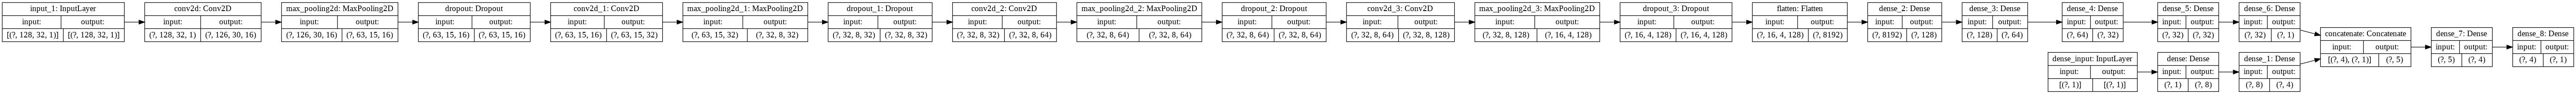

In [ ]:
from keras.utils.vis_utils import plot_model
def create_model_cnn():

  inputA = Input(shape=(128,32,1))
  init = tf.keras.initializers.GlorotNormal(seed = 0)

  x = (Conv2D(16, kernel_size=(3, 3), activation='relu', kernel_initializer = init, bias_regularizer='l1'))(inputA)
  x = (MaxPooling2D(pool_size=(2, 2),padding = "same"))(x)
  x = (Dropout(0.2))(x)
  x = (Conv2D(32, kernel_size=(3, 3), activation='relu', kernel_initializer = init, bias_regularizer='l1',padding = "same"))(x)
  x = (MaxPooling2D(pool_size=(2, 2),padding = "same"))(x)
  x = (Dropout(0.5))(x)
  x = (Conv2D(64, kernel_size=(3, 3), activation='relu', kernel_initializer = init, bias_regularizer='l1',padding = "same"))(x)
  x = (MaxPooling2D(pool_size=(1, 1),padding = "same"))(x)
  x = (Dropout(0.5))(x)
  x = (Conv2D(128, kernel_size=(3, 3), activation='relu', kernel_initializer = init, bias_regularizer='l2',padding = "same"))(x)
  x = (MaxPooling2D(pool_size=(2, 2),padding = "same"))(x)
  x = (Dropout(0.7))(x)
  x = (Flatten())(x)
  x = (Dense(128, kernel_regularizer = 'l2', activation='relu', kernel_initializer = init))(x)
  x = (Dense(64, kernel_regularizer = 'l2', activation='relu', kernel_initializer = init))(x)
  x = (Dense(32, kernel_regularizer = 'l2', activation='relu', kernel_initializer = init))(x)
  x = (Dense(32, kernel_regularizer = 'l2', activation='relu', kernel_initializer = init))(x)
  x = (Dense(1, activation='sigmoid', kernel_initializer = init))(x)
  model = Model(inputA, x)
  return model

def create_model_mlp():
  model = Sequential()
  model.add(Dense(8, input_dim=1, activation="relu"))
  model.add(Dense(4, activation="sigmoid"))
	# return our model
  return model
  

mlp = create_model_mlp()
cnn = create_model_cnn()
combinedInput = concatenate([mlp.output, cnn.output])
x = Dense(4, activation="relu")(combinedInput)
x = Dense(1, activation="sigmoid")(x)
model = Model(inputs=[mlp.input, cnn.input], outputs=x)
plot_model(model, to_file='model_plot.png',rankdir='LR', show_shapes=True, show_layer_names=True)

In [ ]:
# Model configuration:
batch_size = 16
img_width, img_height = 126, 32
loss_function = BinaryCrossentropy()
#no_epochs = 45
optimizer = Adam(learning_rate = 0.001)
#input_shape = (img_width, img_height, 1)
init = tf.keras.initializers.GlorotNormal(seed = 0)

# Creating and running the model
#model = create_model(input_shape, init)  
model.compile(loss=loss_function, optimizer=optimizer, metrics=[AUC(), 'accuracy'])


In [ ]:
model.summary()

Model: "functional_15"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 128, 32, 1)] 0                                            
__________________________________________________________________________________________________
conv2d_12 (Conv2D)              (None, 126, 30, 16)  160         input_4[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_12 (MaxPooling2D) (None, 63, 15, 16)   0           conv2d_12[0][0]                  
__________________________________________________________________________________________________
dropout_12 (Dropout)            (None, 63, 15, 16)   0           max_pooling2d_12[0][0]           
______________________________________________________________________________________

In [ ]:
history = model.fit(
	x=[xTrain_geo, xTrain_abs],
	 y=yTrain ,epochs=30, batch_size=16,
	  validation_data = ([xTest_geo, xTest_abs],yTest))

Epoch 1/30
344/344 [==============================] - 4s 10ms/step - loss: 0.8621 - auc_2: 0.6595 - accuracy: 0.8380 - val_loss: 0.4151 - val_auc_2: 0.9363 - val_accuracy: 0.8336
Epoch 2/30
344/344 [==============================] - 3s 9ms/step - loss: 0.3794 - auc_2: 0.9246 - accuracy: 0.8380 - val_loss: 0.3497 - val_auc_2: 0.9437 - val_accuracy: 0.8336
Epoch 3/30
344/344 [==============================] - 3s 9ms/step - loss: 0.3110 - auc_2: 0.9334 - accuracy: 0.8380 - val_loss: 0.2821 - val_auc_2: 0.9466 - val_accuracy: 0.8336
Epoch 4/30
344/344 [==============================] - 3s 9ms/step - loss: 0.2572 - auc_2: 0.9497 - accuracy: 0.8380 - val_loss: 0.2347 - val_auc_2: 0.9587 - val_accuracy: 0.8336
Epoch 5/30
344/344 [==============================] - 3s 9ms/step - loss: 0.2200 - auc_2: 0.9602 - accuracy: 0.8658 - val_loss: 0.2084 - val_auc_2: 0.9697 - val_accuracy: 0.9237
Epoch 6/30
344/344 [==============================] - 3s 9ms/step - loss: 0.2071 - auc_2: 0.9676 - accuracy: 

####################################################################################33

In [ ]:
# Function for calculating the final ROC-AUC score and plot the ROC curve,
# used in the "Results" section
def stats(pred, actual):
  """
  Computes the model ROC-AUC score and plots the ROC curve.

  Arguments:
    pred -- {ndarray} -- model's probability predictions
    actual -- the true lables

  Returns:
    ROC curve graph and ROC-AUC score
  """
  plt.figure(figsize=(20, 10))
  fpr1, tpr1, _ = roc_curve(actual[0], pred[0])
  fpr2, tpr2, _ = roc_curve(actual[1], pred[1])
  roc_auc = [auc(fpr1, tpr1), auc(fpr2, tpr2)]
  lw = 2
  plt.plot(fpr1, tpr1, lw=lw, label='Training set (ROC-AUC = %0.2f)' % roc_auc[0])
  plt.plot(fpr2, tpr2, lw=lw, label='Validation set (ROC-AUC = %0.2f)' % roc_auc[1])
  plt.plot([0, 1], [0, 1], color='black', lw=lw, linestyle='--', label = 'Random guess')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate', fontsize=18)
  plt.ylabel('True Positive Rate', fontsize=18)
  plt.title('Training set vs. Validation set ROC curves')
  plt.legend(loc="lower right", prop = {'size': 20})
  plt.show()

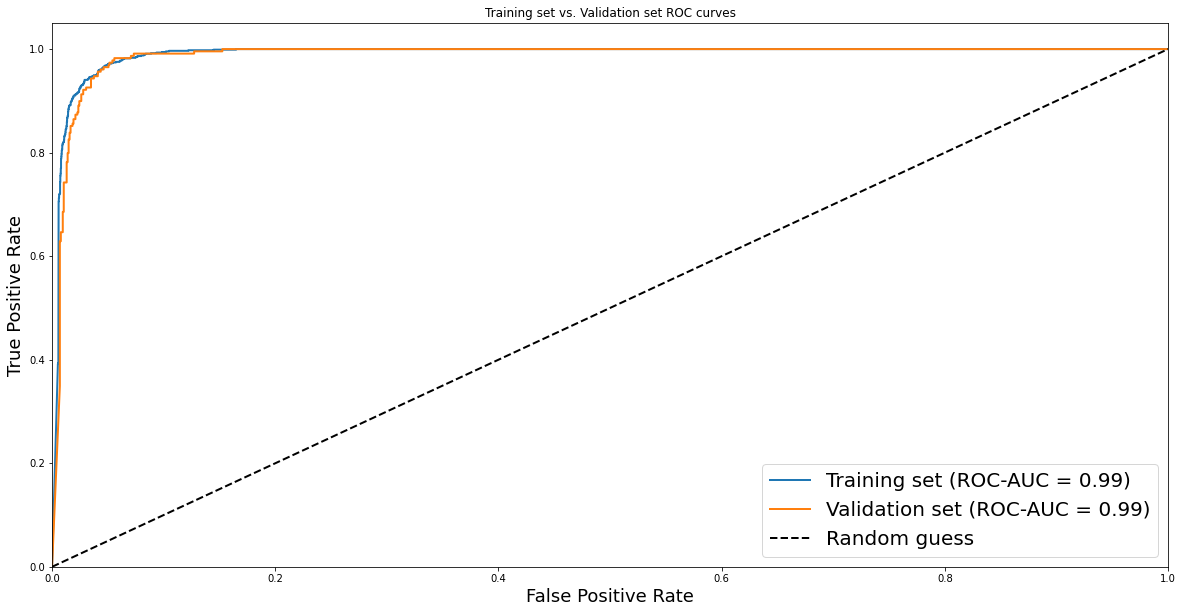

In [ ]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

pred = [model.predict([xTrain_geo, xTrain_abs]), model.predict([xTest_geo, xTest_abs])]
actual = [yTrain, yTest]
stats(pred, actual)

In [ ]:
!pip install -q pyyaml h5py  # Required to save models in HDF5 format

In [ ]:
model.save('/content/sample_data')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: /content/sample_data/assets


In [ ]:
new_model = tf.keras.models.load_model('/content/sample_data/')

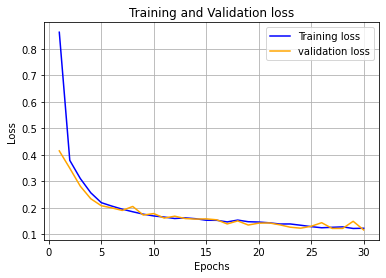

In [ ]:
loss_train = history.history['loss']
loss_val = history.history['val_loss']
epochs = range(1,31)
plt.plot(epochs, loss_train, 'b', label='Training loss')
plt.plot(epochs, loss_val, 'orange', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

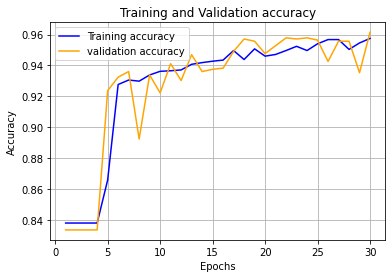

In [ ]:
loss_train = history.history['accuracy']
loss_val = history.history['val_accuracy']
epochs = range(1,31)
plt.plot(epochs, loss_train, 'b', label='Training accuracy')
plt.plot(epochs, loss_val, 'orange', label='validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()